In [ ]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [2]:
# MSDL connectivity matrices for nilearn connectome

import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

run_num = 3
runs = list(range(1, run_num + 1))

def verify_standard_space(img):
    """Verify image is in 2mm standard space"""
    if img.shape[:3] != (91, 109, 91):
        logging.warning(f"Unexpected shape: {img.shape}")
        return False
    
    vox_size = np.sqrt(np.sum(img.affine[:3, :3] ** 2, axis=0))
    if not np.allclose(vox_size, [2., 2., 2.], atol=0.1):
        logging.warning(f"Unexpected voxel size: {vox_size}")
        return False
    
    return True

def create_connectivity_matrix(ss):
    """Create connectivity matrix using MSDL atlas"""
    logging.info(f"Processing subject: {ss}")
    
    # Load MSDL atlas
    atlas = datasets.fetch_atlas_msdl()
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load standard space data
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Standard space data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Verify standard space
        if not verify_standard_space(subject_img):
            logging.warning(f"Data not in expected standard space for {ss} run-{rn}")
            continue
        
        # Extract time series using the MSDL atlas
        masker = NiftiMapsMasker(
            maps_img=atlas_img,
            standardize=True,
            memory='nilearn_cache',
            verbose=0
        )
        
        time_series = masker.fit_transform(subject_img)
        all_runs_data.append(time_series)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    # Create output directory if it doesn't exist
    output_dir = f'{results_dir}/connectivity_matrices_MSDL'
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each subject
    for ss in subs:
        try:
            connectivity_matrix = create_connectivity_matrix(ss)
            if connectivity_matrix is not None:
                output_path = f'{output_dir}/{ss}_connectivity_matrix_MSDL.npy'
                np.save(output_path, connectivity_matrix)
                logging.info(f'Saved MSDL connectivity matrix for {ss} at {output_path}')
                logging.info(f'Matrix shape: {connectivity_matrix.shape}')  # Should be (39, 39) for MSDL
        except Exception as e:
            logging.error(f"Error processing subject {ss}: {str(e)}")
            continue

if __name__ == "__main__":
    main()

2024-11-12 10:42:17,969 - INFO - Processing subject: sub-025
2024-11-12 10:43:30,586 - INFO - Saved MSDL connectivity matrix for sub-025 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-025_connectivity_matrix_MSDL.npy
2024-11-12 10:43:30,588 - INFO - Matrix shape: (39, 39)
2024-11-12 10:43:30,589 - INFO - Processing subject: sub-038
2024-11-12 10:44:29,157 - INFO - Saved MSDL connectivity matrix for sub-038 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-038_connectivity_matrix_MSDL.npy
2024-11-12 10:44:29,159 - INFO - Matrix shape: (39, 39)
2024-11-12 10:44:29,160 - INFO - Processing subject: sub-057
2024-11-12 10:45:30,171 - INFO - Saved MSDL connectivity matrix for sub-057 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-057_connectivity_matrix_MSDL.npy
2024-11-12 10:45:30,173 - INFO - Matrix shape: (39, 39)
2024-11-12 10:45:30,174 - INFO - Processing subject: sub-059
2024-11-12 10:46:31,143 - INFO

2024-11-12 11:10:40,291 - INFO - Loaded matrix for subject sub-025
2024-11-12 11:10:40,294 - INFO - Loaded matrix for subject sub-038
2024-11-12 11:10:40,296 - INFO - Loaded matrix for subject sub-057
2024-11-12 11:10:40,299 - INFO - Loaded matrix for subject sub-059


2024-11-12 11:10:40,302 - INFO - Loaded matrix for subject sub-064
2024-11-12 11:10:40,304 - INFO - Loaded matrix for subject sub-067
2024-11-12 11:10:40,307 - INFO - Loaded matrix for subject sub-068
2024-11-12 11:10:40,309 - INFO - Loaded matrix for subject sub-071
2024-11-12 11:10:40,312 - INFO - Loaded matrix for subject sub-083
2024-11-12 11:10:40,314 - INFO - Loaded matrix for subject sub-084
2024-11-12 11:10:40,317 - INFO - Loaded matrix for subject sub-085
2024-11-12 11:10:40,320 - INFO - Loaded matrix for subject sub-087
2024-11-12 11:10:40,322 - INFO - Loaded matrix for subject sub-088
2024-11-12 11:10:40,325 - INFO - Loaded matrix for subject sub-093
2024-11-12 11:10:40,327 - INFO - Loaded matrix for subject sub-094
2024-11-12 11:10:40,330 - INFO - Loaded matrix for subject sub-095
2024-11-12 11:10:40,332 - INFO - Loaded matrix for subject sub-096
2024-11-12 11:10:40,334 - INFO - Loaded matrix for subject sub-097
2024-11-12 11:10:40,337 - INFO - Loaded matrix for subject sub

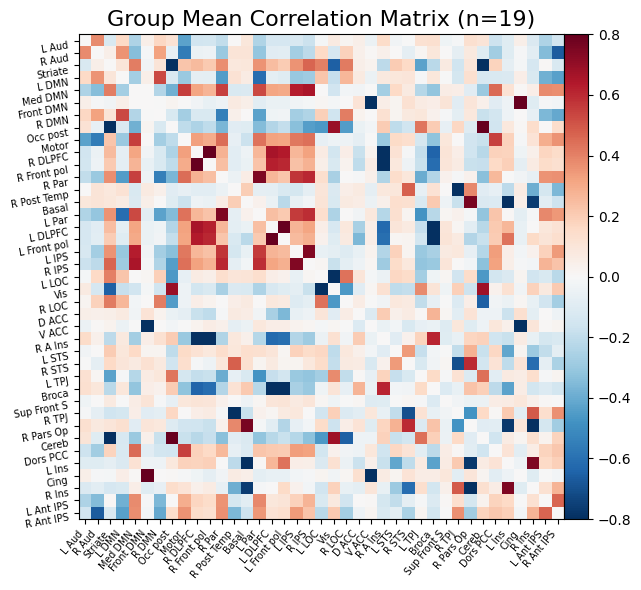

<Figure size 800x600 with 0 Axes>

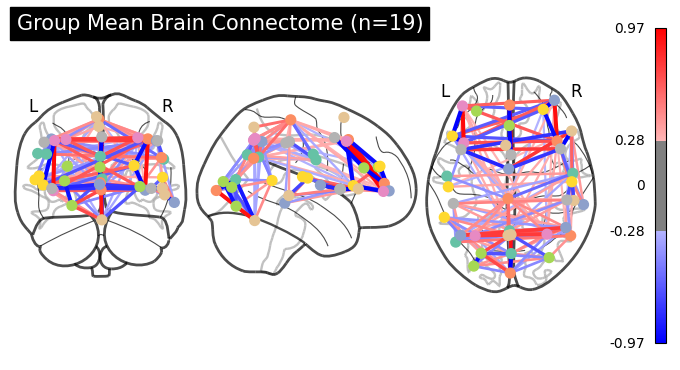


Group-Level Connectivity Statistics:
Number of subjects: 19
Shape: (39, 39)
Value range: [-0.966, 1.000]
Number of regions: 39


In [5]:
# MSDL connectivity visuals for nilearn connectome
import os
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load subject information
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix_dir = f'{results_dir}/connectivity_matrices_MSDL'

# Load MSDL atlas for labels and coordinates
atlas = datasets.fetch_atlas_msdl()
labels = atlas.labels
coords = atlas.region_coords

def load_all_matrices():
    """Load and average matrices across all subjects"""
    all_matrices = []
    
    for sub in subs:
        matrix_path = f'{matrix_dir}/{sub}_connectivity_matrix_MSDL.npy'
        if os.path.exists(matrix_path):
            try:
                matrix = np.load(matrix_path)
                all_matrices.append(matrix)
                logging.info(f"Loaded matrix for subject {sub}")
            except Exception as e:
                logging.error(f"Error loading matrix for {sub}: {str(e)}")
    
    if not all_matrices:
        raise ValueError("No matrices were successfully loaded")
    
    # Calculate mean and standard deviation across subjects
    mean_matrix = np.mean(all_matrices, axis=0)
    std_matrix = np.std(all_matrices, axis=0)
    
    return mean_matrix, std_matrix, len(all_matrices)

def create_group_visualizations(mean_matrix, std_matrix, n_subjects):
    """Create group-level visualizations"""
    # Plot 1: Correlation Matrix
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = plt.subplot(121)
    matrix_plot = mean_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    plotting.plot_matrix(
        matrix_plot,
        labels=labels,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title=f'Group Mean Correlation Matrix (n={n_subjects})',
        axes=ax1
    )
    
    # Plot 2: Brain Connectome as separate figure
    fig_connectome = plt.figure(figsize=(8, 6))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="80%",
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome (n={n_subjects})',
        display_mode='ortho'
    )
    
    # Show both plots
    plt.show()
    
    # Create interactive 3D view
    view = plotting.view_connectome(
        mean_matrix,
        coords,
        edge_threshold="0%"
    )
    #view.open_in_browser()
    
    # Print connectivity statistics
    print("\nGroup-Level Connectivity Statistics:")
    print(f"Number of subjects: {n_subjects}")
    print(f"Shape: {mean_matrix.shape}")
    print(f"Value range: [{mean_matrix.min():.3f}, {mean_matrix.max():.3f}]")
    print(f"Number of regions: {len(labels)}")

def main():
    try:
        # Load and average all matrices
        mean_matrix, std_matrix, n_subjects = load_all_matrices()
        
        # Create group-level visualizations
        create_group_visualizations(mean_matrix, std_matrix, n_subjects)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

2024-11-12 11:17:04,761 - INFO - Loaded matrix for subject sub-025
2024-11-12 11:17:04,764 - INFO - Loaded matrix for subject sub-038
2024-11-12 11:17:04,766 - INFO - Loaded matrix for subject sub-057
2024-11-12 11:17:04,768 - INFO - Loaded matrix for subject sub-059
2024-11-12 11:17:04,769 - INFO - Loaded matrix for subject sub-064
2024-11-12 11:17:04,772 - INFO - Loaded matrix for subject sub-067
2024-11-12 11:17:04,774 - INFO - Loaded matrix for subject sub-068
2024-11-12 11:17:04,776 - INFO - Loaded matrix for subject sub-071
2024-11-12 11:17:04,777 - INFO - Loaded matrix for subject sub-083
2024-11-12 11:17:04,780 - INFO - Loaded matrix for subject sub-084
2024-11-12 11:17:04,782 - INFO - Loaded matrix for subject sub-085
2024-11-12 11:17:04,784 - INFO - Loaded matrix for subject sub-087
2024-11-12 11:17:04,786 - INFO - Loaded matrix for subject sub-088
2024-11-12 11:17:04,788 - INFO - Loaded matrix for subject sub-093
2024-11-12 11:17:04,790 - INFO - Loaded matrix for subject sub


Group-Level Connectivity Statistics:
Number of subjects: 19
Matrix shape: (39, 39)
Mean correlation range: [-0.966, 1.000]
Standard deviation range: [0.000, 0.423]

ROI-specific connections:
L LOC <-> R LOC: 0.431 ± 0.200
L LOC <-> L IPS: -0.057 ± 0.423
L LOC <-> R IPS: 0.014 ± 0.354
L LOC <-> L Ant IPS: -0.122 ± 0.225
L LOC <-> R Ant IPS: -0.214 ± 0.221
R LOC <-> L IPS: -0.104 ± 0.299
R LOC <-> R IPS: -0.080 ± 0.396
R LOC <-> L Ant IPS: -0.154 ± 0.212
R LOC <-> R Ant IPS: -0.270 ± 0.215
L IPS <-> R IPS: 0.743 ± 0.110
L IPS <-> L Ant IPS: 0.183 ± 0.204
L IPS <-> R Ant IPS: 0.342 ± 0.180
R IPS <-> L Ant IPS: 0.274 ± 0.181
R IPS <-> R Ant IPS: 0.228 ± 0.246
L Ant IPS <-> R Ant IPS: 0.468 ± 0.194


<Figure size 640x480 with 0 Axes>

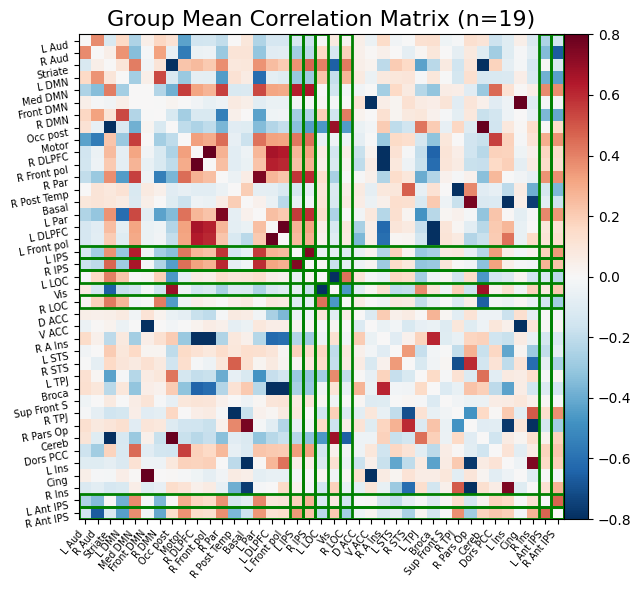

<Figure size 800x800 with 0 Axes>

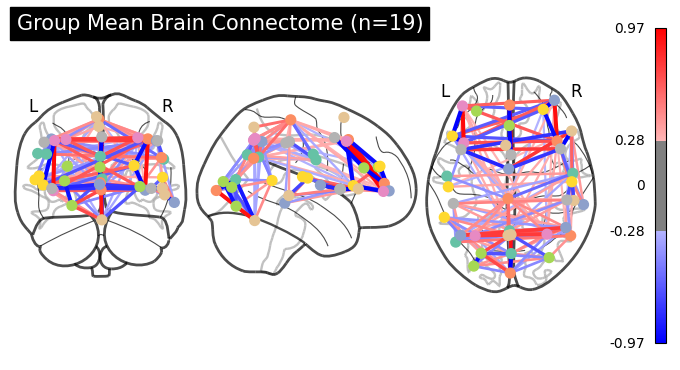

In [10]:
#highlight roi
import os
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load subject information
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix_dir = f'{results_dir}/connectivity_matrices_MSDL'

# Load MSDL atlas for labels and coordinates
atlas = datasets.fetch_atlas_msdl()
labels = atlas.labels
coords = atlas.region_coords

def create_group_visualizations(mean_matrix, std_matrix, n_subjects):
    
    """Create group-level visualizations with highlighted ROIs"""
    # Explicitly create a new figure
    plt.clf()  # Clear any existing figures
    fig = plt.figure(figsize=(15, 6))
    
    # Plot 1: Mean Correlation Matrix
    ax1 = plt.subplot(121)
    matrix_plot = mean_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    # Create ROI indices with correct MSDL atlas labels
    roi_names = ['L LOC', 'R LOC', 'L IPS', 'R IPS', 'L Ant IPS', 'R Ant IPS']
    roi_indices = [labels.index(roi) for roi in roi_names]
    
    # Plot the matrix
    plotting.plot_matrix(
        matrix_plot,
        labels=labels,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title=f'Group Mean Correlation Matrix (n={n_subjects})',
        axes=ax1
    )
    
    # Add highlighting for ROIs
    n_labels = len(labels)
    for idx in roi_indices:
        # Highlight row
        ax1.add_patch(plt.Rectangle((-0.5, idx - 0.5), n_labels, 1, 
                                  fill=False, edgecolor='green', lw=2))
        # Highlight column
        ax1.add_patch(plt.Rectangle((idx - 0.5, -0.5), 1, n_labels, 
                                  fill=False, edgecolor='green', lw=2))
    
    # Save the correlation matrix plot
    #plt.savefig(f'{results_dir}/msdl_correlation_matrix_highlighted.png', 
                #dpi=300, bbox_inches='tight')
    
    # Create a new figure for the connectome
    plt.figure(figsize=(8, 8))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="80%",
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome (n={n_subjects})'
    )
    
    # Save the connectome plot
    #plt.savefig(f'{results_dir}/msdl_connectome.png', 
                #dpi=300, bbox_inches='tight')
    
    # Close all figures to free memory
    #plt.close('all')
    
    # Create interactive 3D view
    view = plotting.view_connectome(
        mean_matrix,
        coords,
        edge_threshold="80%"
    )
    #view.open_in_browser()
    
    # Print group-level statistics
    print("\nGroup-Level Connectivity Statistics:")
    print(f"Number of subjects: {n_subjects}")
    print(f"Matrix shape: {mean_matrix.shape}")
    print(f"Mean correlation range: [{mean_matrix.min():.3f}, {mean_matrix.max():.3f}]")
    print(f"Standard deviation range: [{std_matrix.min():.3f}, {std_matrix.max():.3f}]")
    
    # Add specific analysis of ROI connections
    print("\nROI-specific connections:")
    for i, roi1 in enumerate(roi_names):
        idx1 = labels.index(roi1)
        for roi2 in roi_names[i+1:]:
            idx2 = labels.index(roi2)
            correlation = mean_matrix[idx1, idx2]
            std = std_matrix[idx1, idx2]
            print(f"{roi1} <-> {roi2}: {correlation:.3f} ± {std:.3f}")\

def main():
    try:
        # Load and average all matrices
        mean_matrix, std_matrix, n_subjects = load_all_matrices()
        
        # Create group-level visualizations
        create_group_visualizations(mean_matrix, std_matrix, n_subjects)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

In [3]:
import os
import logging
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker
from sklearn.covariance import GraphicalLassoCV
import matplotlib.pyplot as plt
import ptoc_params as params

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def setup_directories(base_dir):
    """Setup directory structure for results"""
    results_dir = f'{base_dir}/results/connectivity_analysis'
    for subdir in ['individual', 'group', 'combined']:
        os.makedirs(f'{results_dir}/{subdir}', exist_ok=True)
    return results_dir

def extract_time_series(subject, run, atlas):
    """Extract time series data for a single run using MSDL atlas"""
    run_path = f'{params.raw_dir}/{subject}/ses-01/derivatives/fsl/loc/run-0{run}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
    
    if not os.path.exists(run_path):
        logging.warning(f'Standard space data not found: {run_path}')
        return None
        
    masker = NiftiMapsMasker(
        maps_img=atlas.maps,
        resampling_target="maps",
        detrend=True,
        high_variance_confounds=True,
        low_pass=None,
        high_pass=0.01,
        t_r=2,
        standardize="zscore_sample",
        standardize_confounds="zscore_sample",
        memory="nilearn_cache",
        memory_level=1,
        verbose=2
    )
    
    return masker.fit_transform(run_path)

def prepare_subject_data(subject, atlas):
    """Prepare all runs for a subject with data validation"""
    all_runs = []
    for run in range(1, 4):
        time_series = extract_time_series(subject, run, atlas)
        if time_series is not None:
            # Check for invalid values
            logging.info(f"Run {run} shape: {time_series.shape}")
            logging.info(f"NaN values: {np.isnan(time_series).sum()}")
            logging.info(f"Inf values: {np.isinf(time_series).sum()}")
            logging.info(f"Value range: {time_series.min()} to {time_series.max()}")
            
            all_runs.append(time_series)
    
    if not all_runs:
        return None
        
    # Concatenate and check final time series
    final_ts = np.concatenate(all_runs, axis=0)
    logging.info(f"Final time series shape: {final_ts.shape}")
    logging.info(f"Final NaN values: {np.isnan(final_ts).sum()}")
    logging.info(f"Final Inf values: {np.isinf(final_ts).sum()}")
    
    return final_ts

def individual_analysis(time_series, subject, results_dir):
    """Perform individual subject analysis using GraphicalLassoCV"""
    logging.info(f"Running individual analysis for subject {subject}")
    
    gl = GraphicalLassoCV(verbose=2)
    gl.fit(time_series)
    
    return gl.covariance_, gl.precision_, gl.alpha_

def plot_matrices(cov, prec, title, labels, results_dir, subject_id=None):
    """Plot covariance and precision matrices, following nilearn example"""
    prec = prec.copy()  # avoid side effects
    
    # Put zeros on the diagonal, for graph clarity
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Display covariance matrix
    plotting.plot_matrix(
        cov,
        cmap=plotting.cm.bwr,
        vmin=-1,
        vmax=1,
        title=f"{title} / covariance",
        labels=labels,
        axes=ax1
    )
    
    # Display precision matrix
    plotting.plot_matrix(
        prec,
        cmap=plotting.cm.bwr,
        vmin=-span,
        vmax=span,
        title=f"{title} / precision",
        labels=labels,
        axes=ax2
    )
    
    plt.tight_layout()
    
    # Save with subject ID if it's individual analysis
    filename = f'{results_dir}/individual/matrices_{subject_id}.png'
    plt.savefig(filename)
    plt.close()

def main(single_subject=None):
    """
    Run analysis pipeline
    Args:
        single_subject: If provided, only analyze this subject
    """
    # Setup
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = setup_directories(curr_dir)
    
    # Load subject info
    sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
    subjects_to_skip = []
    subs = sub_info[
        (sub_info['group'] == 'control') & 
        (~sub_info['sub'].isin(subjects_to_skip))
    ]['sub'].tolist()
    
    # Filter for single subject if specified
    if single_subject:
        if single_subject in subs:
            subs = [single_subject]
        else:
            raise ValueError(f"Subject {single_subject} not found in control group")
    
    # Load MSDL atlas
    atlas = datasets.fetch_atlas_msdl()
    
    try:
        # Individual analyses
        individual_results = {}
        for subject in subs:
            time_series = prepare_subject_data(subject, atlas)
            if time_series is not None:
                covariance, precision, alpha = individual_analysis(
                    time_series, subject, results_dir
                )
                individual_results[subject] = {
                    'time_series': time_series,
                    'covariance': covariance,
                    'precision': precision,
                    'alpha': alpha
                }
                
                # Plot individual results
                plot_matrices(
                    covariance, 
                    precision, 
                    f"Individual Subject {subject}", 
                    atlas.labels,
                    results_dir,
                    subject
                )
                
                # Save matrices for future use
                np.save(f'{results_dir}/individual/covariance_{subject}.npy', covariance)
                np.save(f'{results_dir}/individual/precision_{subject}.npy', precision)
                
                logging.info(f"Completed analysis for subject {subject}")
                logging.info(f"Alpha value: {alpha}")
                
        logging.info("\nProcessing complete!")
        logging.info(f"Number of subjects processed: {len(individual_results)}")
        logging.info(f"Results saved in: {results_dir}")
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    # Run for single subject
    #main(single_subject='sub-107')
    main()

2024-11-12 17:37:32,369 - INFO - Run 1 shape: (184, 39)
2024-11-12 17:37:32,370 - INFO - NaN values: 0
2024-11-12 17:37:32,371 - INFO - Inf values: 0
2024-11-12 17:37:32,372 - INFO - Value range: -4.077289113647004 to 4.185634172016069


[Memory]0.0s, 0.0min    : Loading high_variance_confounds...
[Memory]0.1s, 0.0min    : Loading _filter_and_extract...
[NiftiMapsMasker.wrapped] loading regions from None


KeyboardInterrupt: 

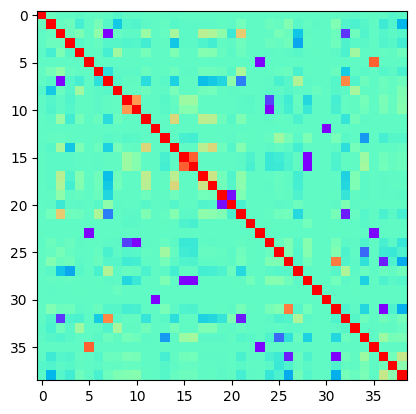

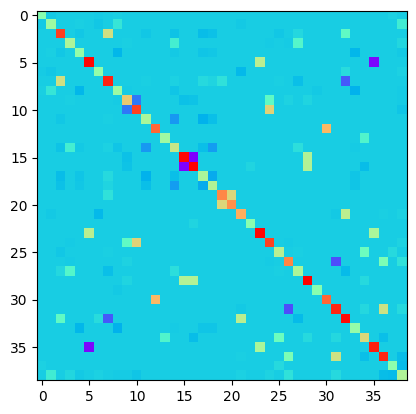

In [10]:
import numpy as np
import nibabel as nib
import nilearn.plotting as plotting
import matplotlib.pyplot as plt

# Load the .npy file_1
img_array = np.load('results/connectivity_analysis/individual/covariance_sub-107.npy')
plt.imshow(img_array, cmap='rainbow')
plt.show()

# Load the .npy file_2
img_array = np.load('results/connectivity_analysis/individual/precision_sub-107.npy')
plt.imshow(img_array, cmap='rainbow')
plt.show()

<Figure size 2000x1000 with 0 Axes>

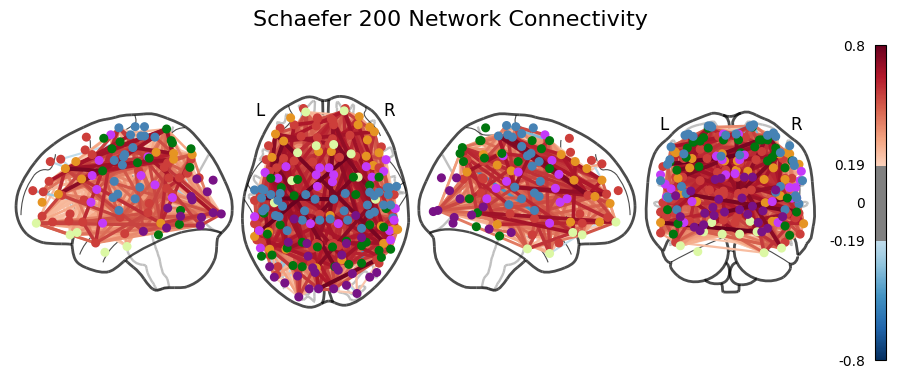

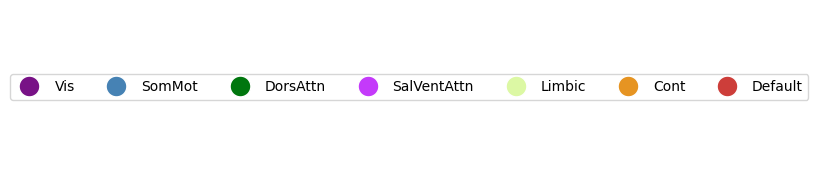


Network Distribution:
Vis: 25 ROIs
SomMot: 37 ROIs
DorsAttn: 31 ROIs
SalVentAttn: 22 ROIs
Limbic: 10 ROIs
Cont: 25 ROIs
Default: 50 ROIs

Connectivity Statistics:
Mean absolute connectivity: 0.061
Max positive connectivity: 0.792
Max negative connectivity: -0.471

Strongest Positive Connections:
7networks_RH_DorsAttn_TempOcc_4 <-> 7networks_LH_Vis_Striate_2: 0.776
7networks_RH_Limbic_OFC_2 <-> 7networks_LH_Cont_Temp: 0.791
7networks_LH_Cont_Temp <-> 7networks_RH_Limbic_OFC_2: 0.791
7networks_LH_SomMot_12 <-> 7networks_RH_SomMot_5: 0.792
7networks_RH_SomMot_5 <-> 7networks_LH_SomMot_12: 0.792


In [ ]:
# remapping schaefer 200 atlas to work with nilearn glass brain
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt

# Load your correlation matrix
matrix_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
correlation_matrix = np.load(matrix_path)

# Load coordinates from saved file
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_1mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

# Define network colors (Yeo7 standard colors)
network_colors = {
    'Vis': '#781286',       # Purple
    'SomMot': '#4682B4',    # Blue
    'DorsAttn': '#00760E',  # Green
    'SalVentAttn': '#C43AFA',  # Magenta
    'Limbic': '#DCF8A4',    # Light green/yellow
    'Cont': '#E69422',      # Orange
    'Default': '#CD3E3A'    # Red
}

# Extract network names from ROI names and map to colors
network_names = [name.split('_')[2] for name in coords_df['ROI Name']]
node_colors = [network_colors[network] for network in network_names]

# Create connectome plot
plt.figure(figsize=(20, 10))
display = plotting.plot_connectome(
    correlation_matrix,
    coords,
    edge_threshold='90%',  # Showing more connections for better visualization
    node_size=30,
    node_color=node_colors,
    display_mode='lzry',   # Multiple views
    edge_vmin=-0.8,
    edge_vmax=0.8,
    colorbar=True,
    edge_cmap='RdBu_r'     # Red-Blue colormap for negative-positive correlations
)
plt.suptitle('Schaefer 200 Network Connectivity', fontsize=16, y=1.05)

# Add legend
legend_fig = plt.figure(figsize=(10, 2))
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=network, markersize=15)
                  for network, color in network_colors.items()]
plt.legend(handles=legend_elements, loc='center', ncol=7)
plt.axis('off')
plt.show()

# Print network statistics
print("\nNetwork Distribution:")
for network in network_colors.keys():
    count = sum(1 for name in network_names if name == network)
    print(f"{network}: {count} ROIs")

print("\nConnectivity Statistics:")
np.fill_diagonal(correlation_matrix, 0)  # Remove diagonal for stats
print(f"Mean absolute connectivity: {np.mean(np.abs(correlation_matrix)):.3f}")
print(f"Max positive connectivity: {np.max(correlation_matrix):.3f}")
print(f"Max negative connectivity: {np.min(correlation_matrix):.3f}")

# Show strongest connections
print("\nStrongest Positive Connections:")
top_positive = np.unravel_index(np.argsort(correlation_matrix.ravel())[-5:], correlation_matrix.shape)
for i, j in zip(top_positive[0], top_positive[1]):
    if i != j:  # Skip diagonal
        print(f"{coords_df['ROI Name'][i]} <-> {coords_df['ROI Name'][j]}: {correlation_matrix[i,j]:.3f}")

<Figure size 1000x800 with 0 Axes>

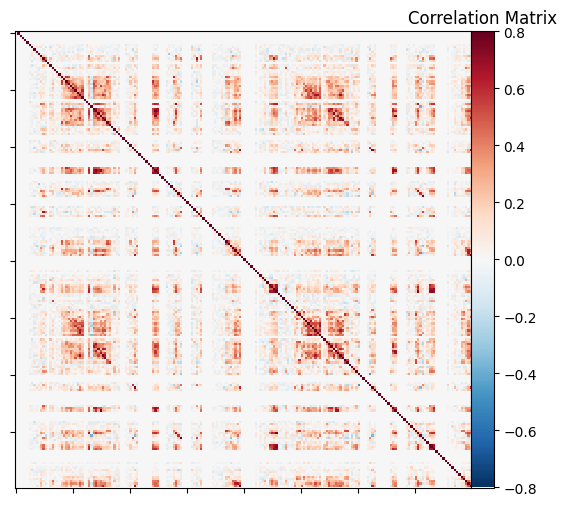

<Figure size 1500x800 with 0 Axes>

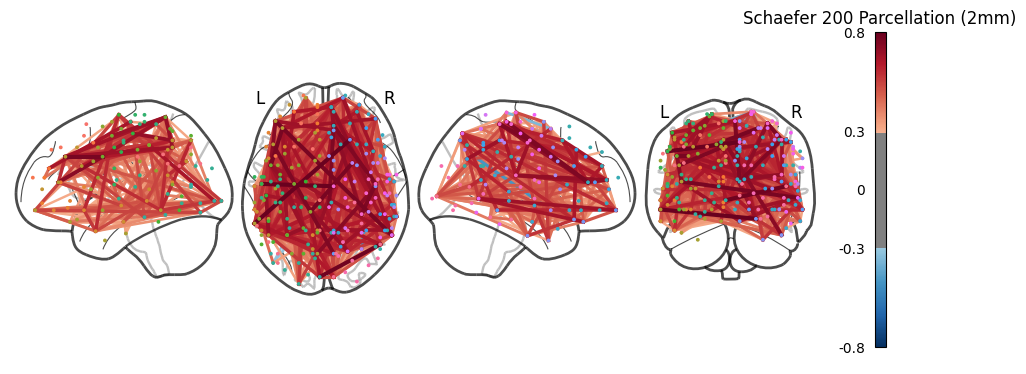


Connectivity Statistics:
Mean absolute connectivity: 0.061
Max positive connectivity: 0.792
Max negative connectivity: -0.471

Strongest Positive Connections:
ROI 7networks_RH_DorsAttn_TempOcc_4 <-> ROI 7networks_LH_Vis_Striate_2: 0.776
ROI 7networks_RH_Limbic_OFC_2 <-> ROI 7networks_LH_Cont_Temp: 0.791
ROI 7networks_LH_Cont_Temp <-> ROI 7networks_RH_Limbic_OFC_2: 0.791
ROI 7networks_LH_SomMot_12 <-> ROI 7networks_RH_SomMot_5: 0.792
ROI 7networks_RH_SomMot_5 <-> ROI 7networks_LH_SomMot_12: 0.792


In [53]:
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load your correlation matrix
matrix_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
correlation_matrix = np.load(matrix_path)

# Load coordinates with the correct 2mm path
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

# Generate random colors
node_colors = sns.color_palette('husl', n_colors=200)

# Create two separate figures for better control
# Figure 1: Matrix
plt.figure(figsize=(10, 8))
plotting.plot_matrix(
    correlation_matrix,
    colorbar=True,
    vmax=0.8,
    vmin=-0.8,
    cmap='RdBu_r'
)
plt.title('Correlation Matrix')
plt.show()

# Figure 2: Brain Connectome
plt.figure(figsize=(15, 8))
plotting.plot_connectome(
    correlation_matrix,
    coords,
    edge_threshold='95%',
    node_size=3,
    node_color=node_colors,
    display_mode='lzry',
    edge_vmin=-0.8,
    edge_vmax=0.8,
    colorbar=True,
    edge_cmap='RdBu_r'
)
plt.title('Schaefer 200 Parcellation (2mm)')
plt.show()

# Print statistics
print("\nConnectivity Statistics:")
np.fill_diagonal(correlation_matrix, 0)  # Remove diagonal for stats
print(f"Mean absolute connectivity: {np.mean(np.abs(correlation_matrix)):.3f}")
print(f"Max positive connectivity: {np.max(correlation_matrix):.3f}")
print(f"Max negative connectivity: {np.min(correlation_matrix):.3f}")

# Show strongest connections
print("\nStrongest Positive Connections:")
top_positive = np.unravel_index(np.argsort(correlation_matrix.ravel())[-5:], correlation_matrix.shape)
for i, j in zip(top_positive[0], top_positive[1]):
    if i != j:  # Skip diagonal
        print(f"ROI {coords_df['ROI Name'][i]} <-> ROI {coords_df['ROI Name'][j]}: {correlation_matrix[i,j]:.3f}")

In [ ]:
# load data
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def load_matrices_simple(results_dir, n_rois=200):
    """
    Simple function to load and average connectivity matrices
    
    Parameters:
    results_dir (str): Directory containing connectivity matrices
    n_rois (int): Number of ROIs (200 or 400)
    
    Returns:
    tuple: (averaged_matrix, region_labels)
    """
    # Load all individual matrices
    #matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}/*_connectivity_matrix.npy')
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices/*[!glasser]_connectivity_matrix.npy') #!glasser to exclude glasser matrices
    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}/connectivity_matrices_{n_rois}/")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    # Load and average matrices
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    # Create simple region labels
    region_labels = [f"Region_{i+1}" for i in range(n_rois)]
    
    return matrix, region_labels


# Set up paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Create figures directory if it doesn't exist
#os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load 200 ROI data
matrix, region_labels = load_matrices_simple(results_dir, n_rois=200)

# Now you can proceed with the visualization functions